<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Matemática Para Data Science, Machine Learning e IA</font>
## <font color='blue'>Projeto 4</font>
### <font color='blue'>Matemática da Arquitetura Transformer e Deploy do Modelo de Forecast de Séries Temporais</font>

ATENÇÃO É TUDO QUE VOCÊ PRECISA!

https://arxiv.org/abs/1706.03762

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Imports
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configurações para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

In [4]:
# Bloco para seleção de dispositivo (CUDA, MPS ou CPU)

if torch.cuda.is_available():
    # Prioridade 1: GPU NVIDIA (CUDA)
    device = torch.device("cuda")
    print("Dispositivo selecionado: GPU NVIDIA (CUDA)")

elif torch.backends.mps.is_available():
    # Prioridade 2: GPU Apple (MPS)
    device = torch.device("mps")
    print("Dispositivo selecionado: GPU Apple (MPS)")

else:
    # Fallback: CPU
    device = torch.device("cpu")
    print("Dispositivo selecionado: CPU")

print(f'Usando dispositivo: {device}')

Dispositivo selecionado: GPU Apple (MPS)
Usando dispositivo: mps


## Preparação dos Dados da Série Temporal

Componentes senoidais são partes de um sinal ou série temporal que variam de forma periódica, seguindo o formato de uma função seno ou cosseno. Elas representam oscilações regulares que se repetem ao longo do tempo. Em termos simples, imagine uma onda que sobe e desce de forma suave e contínua. Esse é o comportamento típico de uma componente senoidal.

Vamos criar dados fictícios. Fique à vontade para experimentar o projeto com outros dados.

In [5]:
# Função para gerar uma série temporal sintética com componentes senoidais e ruído
def dsa_gera_serie_temporal(n_pontos = 1000):
    
    # Cria um vetor de tempo com n_pontos igualmente espaçados
    t = np.arange(n_pontos)
    
    # Gera um sinal senoidal de baixa frequência (período de 50)
    seno1 = np.sin(2 * np.pi * t / 50)
    
    # Gera um segundo sinal senoidal de frequência mais alta (período de 25) e amplitude menor
    seno2 = 0.5 * np.sin(2 * np.pi * t / 25)
    
    # Adiciona ruído aleatório gaussiano para simular imperfeições de medição
    ruido = 0.1 * np.random.randn(n_pontos)
    
    # Combina os dois sinais senoidais e o ruído para formar a série final
    serie = seno1 + seno2 + ruido
    
    # Retorna a série convertida para o tipo float32 para otimizar o uso de memória
    return serie.astype(np.float32)

In [6]:
# Executa a função
serie = dsa_gera_serie_temporal()

In [7]:
len(serie)

1000

In [8]:
type(serie)

numpy.ndarray

In [9]:
serie[0:5]

array([0.12255882, 0.17938554, 0.5486761 , 0.6002801 , 0.8083846 ],
      dtype=float32)

## Visualizando os Dados da Série Temporal

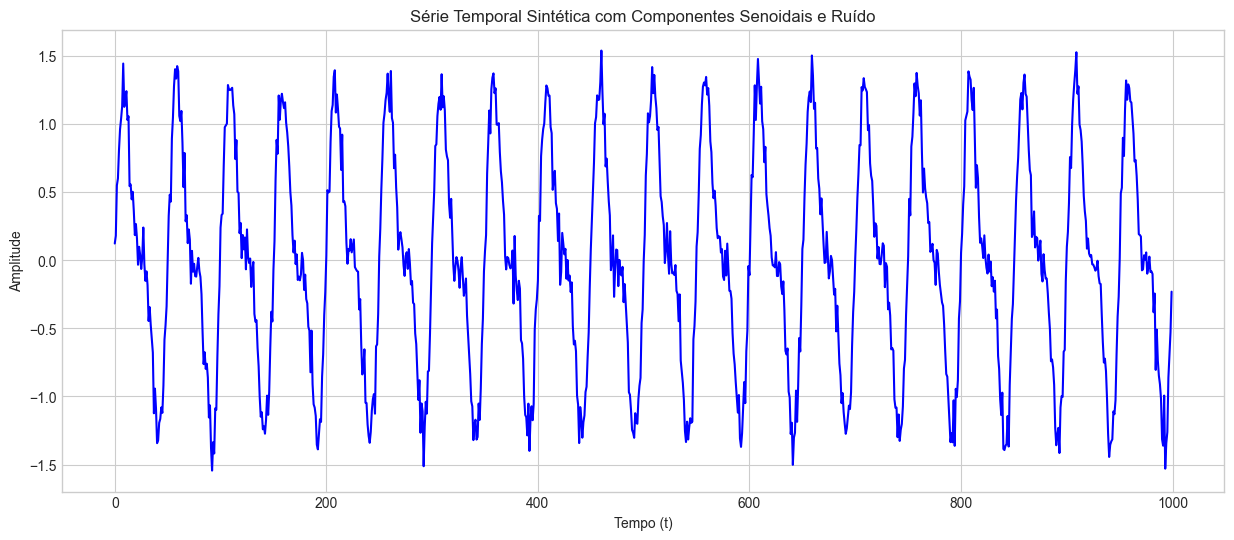

In [10]:
# Cria o eixo de tempo (mesmo tamanho da série)
t = np.arange(len(serie))

# Plot da série
plt.figure(figsize = (15, 6))
plt.plot(t, serie, color = 'blue', linewidth = 1.5)
plt.title("Série Temporal Sintética com Componentes Senoidais e Ruído")
plt.xlabel("Tempo (t)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Vamos visualizar os componentes separadamente para fins didáticos.

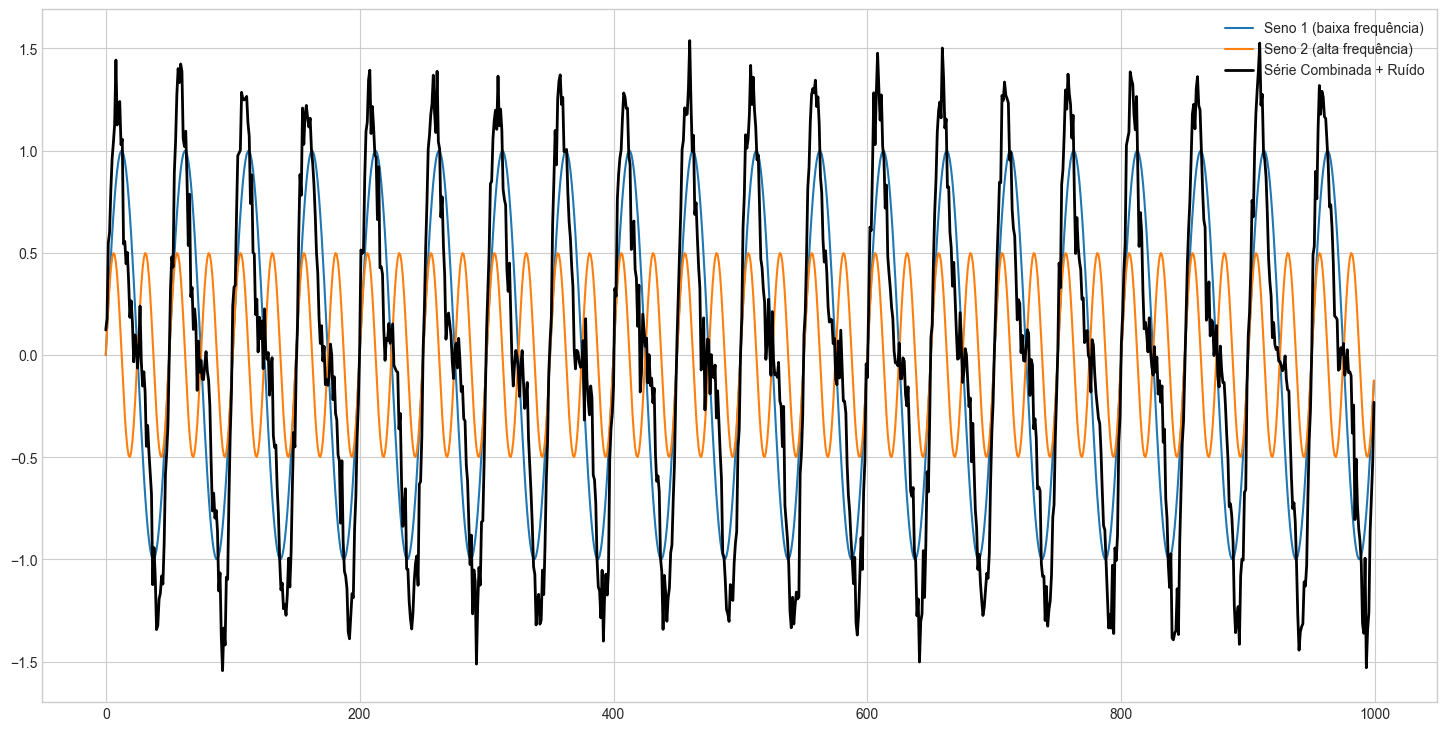

In [11]:
# Plot
plt.figure(figsize = (18, 9))
plt.plot(t, np.sin(2*np.pi*t/50), label = 'Seno 1 (baixa frequência)')
plt.plot(t, 0.5*np.sin(2*np.pi*t/25), label = 'Seno 2 (alta frequência)')
plt.plot(t, serie, label = 'Série Combinada + Ruído', color = 'black', linewidth = 2)
plt.legend(loc='upper right')  
plt.show()

# Divisão em Treino e Teste

In [12]:
# Tamanho da janela
input_window = 50

In [13]:
# Índice para divisão
cutoff = int(len(serie) * 0.8)

In [14]:
# Observe que ao dividir os dados não podemos perder a sequência
serie_train = serie[:cutoff]
serie_test  = serie[cutoff:]

## Normalização dos Dados

In [15]:
# Cria o padronizador
scaler = MinMaxScaler(feature_range = (-1, 1))

In [16]:
# Ajusta SOMENTE nos dados de treino
scaler.fit(serie_train.reshape(-1, 1))         

,"feature_range feature_range: tuple (min, max), default=(0, 1)Desired range of transformed data.","(-1, ...)"
,"copy copy: bool, default=TrueSet to False to perform inplace row normalization and avoid acopy (if the input is already a numpy array).",True
,"clip clip: bool, default=FalseSet to True to clip transformed values of held-out data toprovided `feature_range`.Since this parameter will clip values, `inverse_transform` may notbe able to restore the original data... note:: Setting `clip=True` does not prevent feature drift (a distribution shift between training and test data). The transformed values are clipped to the `feature_range`, which helps avoid unintended behavior in models sensitive to out-of-range inputs (e.g. linear models). Use with care, as clipping can distort the distribution of test data... versionadded:: 0.24",False


In [37]:
# Aplicamos o padronizador aos dados de treino
serie_train_scaled = scaler.transform(serie_train.reshape(-1, 1)).astype(np.float32)

In [18]:
# Aplicamos o padronizador aos dados de teste
serie_test_scaled  = scaler.transform(serie_test.reshape(-1, 1)).astype(np.float32)

## Criando a Sequência de Dados

A arquitetura transformer funciona bem com dados sequenciais. Vamos ajustar os dados para que fiquem no formato adequado de listas de itens. Cada item terá 2 elementos.
<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
Então, mesmo para trabalhar com modelos avançados de IA, precisamos antes trabalhar na matéria-prima, nos dados? Sim, exatamente isso.

In [19]:
# Função para criar sequências de entrada e saída a partir de uma série temporal
def dsa_cria_sequencias(dados, input_window):
    
    # Inicializa uma lista vazia para armazenar as sequências geradas
    sequencias = []
    
    # Calcula o comprimento total dos dados
    L = len(dados)
    
    # Percorre os dados criando janelas deslizantes de tamanho input_window
    for i in range(L - input_window):
        
        # Seleciona um trecho dos dados como sequência de entrada
        seq = dados[i:i + input_window]
        
        # Seleciona o valor seguinte como rótulo (saída esperada)
        label = dados[i + input_window:i + input_window + 1]
        
        # Armazena a tupla (sequência de entrada, rótulo) na lista
        sequencias.append((seq, label))
    
    # Retorna todas as sequências geradas
    return sequencias

In [20]:
# Aplica a função para criação das sequências
train_sequences = dsa_cria_sequencias(serie_train_scaled, input_window)
test_sequences  = dsa_cria_sequencias(serie_test_scaled,  input_window)

In [21]:
type(train_sequences)

list

In [22]:
type(test_sequences)

list

In [23]:
# Tamanho total da sequência de treino
len(train_sequences)

750

In [24]:
# Tamanho total da sequência de teste
len(test_sequences)

150

In [25]:
# Observe que temos 2 elementos em cada item da sequência, ou seja, um par de elementos por item
len(train_sequences[0])

2

In [26]:
# Shape do primeiro elemento do primeiro item
train_sequences[0][0].shape

(50, 1)

In [27]:
# Shape do segundo elemento do primeiro item
train_sequences[0][1].shape

(1, 1)

In [28]:
# Uma matriz de janela 50 representando os dados de entrada e um escalar representa o próximo item na sequência
train_sequences[0]

(array([[ 0.0813111 ],
        [ 0.11818381],
        [ 0.35780248],
        [ 0.3912864 ],
        [ 0.52631754],
        [ 0.62519723],
        [ 0.676133  ],
        [ 0.73465943],
        [ 0.9382841 ],
        [ 0.73219407],
        [ 0.7637062 ],
        [ 0.80674493],
        [ 0.6695831 ],
        [ 0.6868952 ],
        [ 0.35464084],
        [ 0.36280173],
        [ 0.29182047],
        [ 0.3275441 ],
        [ 0.23630922],
        [ 0.1214672 ],
        [ 0.17397295],
        [ 0.10487297],
        [-0.01974895],
        [ 0.06579336],
        [ 0.02787948],
        [-0.03985915],
        [ 0.01569959],
        [ 0.15740572],
        [-0.01912878],
        [-0.09666426],
        [-0.05125054],
        [-0.11688299],
        [-0.28777063],
        [-0.22165515],
        [-0.30634835],
        [-0.37407133],
        [-0.4380615 ],
        [-0.7270561 ],
        [-0.6097089 ],
        [-0.7065514 ],
        [-0.869498  ],
        [-0.85599864],
        [-0.77239585],
        [-0

In [29]:
# Função para converter os dados para o formato de sensor
def dsa_converte_para_tensor(data):
    X = torch.tensor([item[0] for item in data], dtype = torch.float32)
    y = torch.tensor([item[1] for item in data], dtype = torch.float32)
    return X, y

In [30]:
# Aplica a função
X_train, y_train = dsa_converte_para_tensor(train_sequences)
X_test,  y_test  = dsa_converte_para_tensor(test_sequences)

## Criação dos DataLoaders

DataLoaders no PyTorch são objetos que organizam o fluxo de dados durante o treinamento. Eles recebem um dataset e produzem lotes iteráveis e prontos para serem enviados ao modelo. Eles também cuidam de paralelizar a leitura, aplicar transformações e controlar o tamanho dos batches, facilitando o treinamento eficiente.

In [31]:
# Tamanho de cada batch
# Isso é um hiperparâmetro
batch_size = 32

In [32]:
# Cria os objetos do tipo TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test,  y_test)

In [33]:
# Cria os dataloaders
train_loader  = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader   = DataLoader(test_dataset,  batch_size = batch_size, shuffle = False)

Ufa! Terminou a preparação dos dados. Agora sim podemos trabalhar no modelo.

## Função Para o Positional Encoding

https://arxiv.org/pdf/1706.03762

A matemática do Positional Encoding é o que permite que modelos como o Transformer entendam a ordem dos elementos em uma sequência, já que eles não possuem recorrência (RNN) nem estrutura sequencial explícita (como CNNs 1D).

Vamos detalhar de forma conceitual e matemática o que está acontecendo em cada parte.

**1. O Problema: falta de noção de posição**
<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
O Transformer recebe um conjunto de vetores de embeddings, por exemplo, palavras convertidas em vetores. Esses vetores entram simultaneamente e o modelo não tem como saber qual veio antes ou depois.

Para resolver isso, é adicionada uma codificação posicional (Positional Encoding), que injeta informação sobre a posição usando funções de seno e cosseno.

**2. A Ideia Central**

Cada posição na sequência (por exemplo, posição 1, 2, 3, ...) é representada por um vetor que varia de forma suave e periódica. Essas variações seguem funções matemáticas senoidais e cossenoidais com diferentes frequências.

Para uma posição pos e uma dimensão i dentro do embedding (d_model), a fórmula é:

- PE(pos, 2i)   = sin(pos / (10000^(2i / d_model)))
- PE(pos, 2i+1) = cos(pos / (10000^(2i / d_model)))

**3. O Significado de Cada Termo**

pos → o índice da posição na sequência (0, 1, 2, …)

i → o índice da dimensão dentro do vetor de embedding (0 até d_model-1)

d_model → o tamanho do vetor de embedding

10000 → uma constante que controla o espaçamento entre as frequências das ondas

sin e cos → funções periódicas usadas para criar padrões únicos

Essas duas funções (seno e cosseno) garantem que:

- Cada posição tenha um vetor único.

- As distâncias relativas entre posições também possam ser inferidas (importante para atenção). Por exemplo, a diferença entre PE(pos) e PE(pos+k) é quase linearmente relacionada ao deslocamento k.

**4. Intuição Geométrica**

A codificação cria curvas senoidais de diferentes comprimentos de onda.

As dimensões de índice pequeno (i pequeno) mudam lentamente (frequências baixas).

As dimensões maiores mudam rapidamente (frequências altas).

Isso significa que o vetor final é uma combinação de ondas longas e curtas, codificando posição de forma contínua e diferenciável.

**5. Por que usar seno e cosseno?**

Usar senos e cossenos em frequências diferentes permite:

- Codificar posições de forma determinística (não precisa ser aprendida).

- Permitir que o modelo extrapole para comprimentos de sequência maiores que os vistos no treino.

- Manter suavidade e relações diferenciais contínuas entre posições (útil para atenção baseada em dot-product).

**6. Interpretação Prática no Código**

O trecho:

div_term = exp(torch.arange(0, d_model, 2) * (-log(10000.0) / d_model))

cria o denominador 10000^(2i / d_model) da fórmula acima, escalando as frequências para cada dimensão.

E nas linhas:

- pe[:, 0::2] = sin(position * div_term)
- pe[:, 1::2] = cos(position * div_term)

são aplicadas as funções seno e cosseno alternadamente nas dimensões pares e ímpares, gerando o vetor posicional completo.

**7. Resultado Final**

O vetor PE tem o mesmo tamanho que o embedding original (d_model) e é somado ao embedding de entrada: x = x + PE
<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
Assim, o Transformer recebe não só o conteúdo do token (do embedding), mas também a informação de onde ele está na sequência.

In [34]:
# Classe responsável por adicionar codificação posicional aos embeddings de entrada em um Transformer
class PositionalEncoding(nn.Module):
    
    # Método construtor da classe
    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        
        # Inicializa a classe base nn.Module
        super(PositionalEncoding, self).__init__()
        
        # Define uma camada de dropout para regularização (evitar overfitting). Dropout é o desligamento aleatório de neurônios durante o treinamento.
        self.dropout = nn.Dropout(p = dropout)

        # Cria uma matriz de zeros para armazenar as codificações posicionais
        pe = torch.zeros(max_len, d_model)
        
        # Cria um vetor com as posições de 0 até max_len
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        
        # Calcula o termo divisor baseado na frequência de cada dimensão
        # Esse termo controla a variação senoidal conforme o índice da dimensão
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Aplica a função seno nas dimensões pares
        pe[:, 0::2] = torch.sin(position * div_term)
        
        # Aplica a função cosseno nas dimensões ímpares
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Adiciona uma dimensão extra no início para representar o batch (lote)
        pe = pe.unsqueeze(0)
        
        # Registra o tensor como buffer — ele não é aprendido, mas é salvo no modelo
        self.register_buffer('pe', pe)

    # Método forward define o fluxo de dados durante a passagem direta
    def forward(self, x):
        
        # Soma a codificação posicional ao embedding de entrada
        x = x + self.pe[:, :x.size(1), :]
        
        # Aplica o dropout e retorna o resultado
        return self.dropout(x)

## Construindo o Modelo Transformer

A matemática do Transformer aplicado a séries temporais é um dos pontos mais elegantes da arquitetura moderna de Deep Learning. Vamos decompor a explicação do TimeSeriesTransformer em etapas matemáticas, mostrando como cada parte transforma o sinal de entrada e o que ocorre “nos bastidores”.

**1. Entrada e Embedding Linear**

A entrada src tem forma (batch_size, seq_len, input_dim), onde cada ponto no tempo é um vetor com uma ou mais variáveis.

A primeira operação é:

E = W_enc * x + b_enc

onde:

x ∈ ℝ^(input_dim) é o vetor original (por exemplo, um valor de série temporal ou múltiplos sensores).

W_enc ∈ ℝ^(input_dim × d_model) é a matriz de pesos da camada linear.

E ∈ ℝ^(d_model) é o embedding que projeta o dado para o espaço interno do Transformer.

Depois, o código faz:

E = E * sqrt(d_model)

Isso serve apenas para normalizar a magnitude dos embeddings e evitar que fiquem muito pequenos, o que prejudicaria o cálculo dos produtos escalares durante a atenção.

**2. Adição do Positional Encoding**

Os embeddings E são “sem noção de tempo”. Para introduzir ordem temporal, somamos o vetor de posição:

E_pos = E + PE

O vetor PE é calculado como:

- PE(pos, 2i)   = sin(pos / (10000^(2i / d_model)))
- PE(pos, 2i+1) = cos(pos / (10000^(2i / d_model)))

Matematicamente, isso cria uma base contínua de funções periódicas. A ideia é que cada posição pos gere uma assinatura única que varia suavemente entre posições próximas. Assim, o modelo aprende diferenças relativas de posição.

**3. Atenção (Self-Attention)**

A camada TransformerEncoderLayer realiza o mecanismo de atenção, que é o núcleo do modelo.

Cada vetor de entrada x_t (um ponto no tempo) é transformado em três representações diferentes:

- Q_t = x_t * W_Q
- K_t = x_t * W_K
- V_t = x_t * W_V

onde:

- Q_t = Query (consulta)
- K_t = Key (chave)
- V_t = Value (valor)

W_Q, W_K, W_V ∈ ℝ^(d_model × d_k) são matrizes aprendidas.

Esses vetores são então usados para calcular o peso de atenção entre todos os pares de posições (t, s):

attention_score(t, s) = (Q_t · K_s^T) / sqrt(d_k)

O denominador sqrt(d_k) é um fator de normalização (para estabilizar o gradiente). Em seguida, aplica-se softmax para obter as probabilidades de atenção:

α(t, s) = exp(attention_score(t, s)) / Σ_s' exp(attention_score(t, s'))

Por fim, a nova representação contextualizada de cada ponto é:

Z_t = Σ_s α(t, s) * V_s

Ou seja, cada ponto da série “olha” para todos os outros, ponderando sua influência com base nas similaridades de Query e Key.

**4. Multi-Head Attention**

No modelo, o parâmetro nhead = 2 significa que são criadas duas cabeças de atenção independentes. Cada uma aprende a capturar diferentes padrões (curto prazo, longo prazo, tendência, sazonalidade, etc.).

Formalmente:

head_i = Attention(QW_Qi, KW_Ki, VW_Vi)

E depois todas as cabeças são concatenadas:

MultiHead(Q,K,V) = Concat(head_1, head_2, …, head_h) * W_O

**5. Feedforward e Normalização**

Cada camada do Transformer Encoder também contém uma subcamada do tipo Feedforward (duas camadas lineares com uma ativação não linear, geralmente ReLU):

FFN(x) = max(0, xW1 + b1)W2 + b2

Além disso, é aplicada uma camada de normalização e residual connections:

- x = x + Dropout(Attention(...))
- x = LayerNorm(x)
- x = x + Dropout(FFN(x))
- x = LayerNorm(x)

Essas conexões residuais ajudam a manter o fluxo de gradiente e evitar o esquecimento de padrões anteriores.
<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
**6. Agregação Temporal**

Após o empilhamento das camadas de atenção (num_layers = 2), temos uma matriz de saída:

Z ∈ ℝ^(batch_size, seq_len, d_model)

O código faz:

output = Z.mean(dim=1)

Ou seja, calcula a média dos embeddings de todos os instantes de tempo. Isso é uma forma de agregação global e em vez de pegar apenas o último instante, o modelo sintetiza a informação da sequência inteira.

**7. Decodificação (Saída Final)**

Por fim, o vetor médio Z̄ é passado por uma camada linear:

ŷ = Z̄ * W_dec + b_dec

onde:

W_dec ∈ ℝ^(d_model × input_dim)

ŷ ∈ ℝ^(input_dim) é a previsão da próxima observação ou variável alvo.

**8. Resumo Conceitual**

- Projeção Linear: transforma os dados em embeddings (x → E).

- Codificação Posicional: adiciona noção de tempo (E → E + PE).

- Autoatenção: relaciona cada ponto da série com todos os outros (E → Z).

- Feedforward e Normalização: refinam as representações (Z → Z’).

- Agregação Temporal: resume toda a sequência (Z’ → Z̄).

- Decodificação: gera a previsão final (Z̄ → ŷ).

In [ ]:
# Classe que define um modelo Transformer especializado para séries temporais
class TimeSeriesTransformer(nn.Module):
    
    # Método construtor do modelo, com hiperparâmetros ajustáveis
    def __init__(self, input_dim = 1, d_model = 32, nhead = 2, num_layers = 2, dropout = 0.1):
        
        # Inicializa a classe base nn.Module
        super(TimeSeriesTransformer, self).__init__()
        
        # Define o tipo de modelo (apenas para identificação)
        self.model_type = 'Transformer'
        
        # Armazena o tamanho da dimensão do embedding (vetor interno do modelo)
        self.d_model = d_model
        
        # Camada linear para transformar a entrada no espaço de dimensão d_model. Linear é usada para projeção.
        self.encoder = nn.Linear(input_dim, d_model)
        
        # Módulo de codificação posicional para adicionar informação de ordem temporal
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Define uma camada de codificação Transformer padrão do PyTorch
        encoder_layers = nn.TransformerEncoderLayer(
            d_model = d_model,      # dimensão do embedding
            nhead = nhead,          # número de cabeças de atenção
            dropout = dropout,      # taxa de dropout para regularização
            batch_first = True      # garante que o batch seja a primeira dimensão (B, T, D)
        )
        
        # Cria o empilhamento de múltiplas camadas de codificação Transformer
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers = num_layers)
        
        # Camada linear final para mapear de volta à dimensão original da entrada
        self.decoder = nn.Linear(d_model, input_dim)

    # Método que define o fluxo de dados (forward pass)
    def forward(self, src):
        
        # Projeta os dados de entrada para o espaço de embedding e escala pela raiz de d_model
        src = self.encoder(src) * math.sqrt(self.d_model)
        
        # Adiciona as codificações posicionais para preservar a ordem temporal
        src = self.pos_encoder(src)
        
        # Passa as sequências codificadas pelo bloco Transformer
        output = self.transformer_encoder(src)
        
        # Utiliza a média de todas as saídas da sequência para gerar a previsão final
        # (isso é mais estável do que usar apenas o último token)
        output = output.mean(dim=1)
        
        # Passa o resultado pela camada decodificadora para retornar à dimensão original
        output = self.decoder(output)
        
        # Retorna a previsão final da série temporal
        return output

In [38]:
# Cria o objeto (instância da classe) e manda para o device
modelo_dsa = TimeSeriesTransformer().to(device)

In [39]:
print(modelo_dsa)

TimeSeriesTransformer(
  (encoder): Linear(in_features=1, out_features=32, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=32, out_features=1, bias=True)
)


## Função de Erro e Otimizador

Aqui temos dois elementos fundamentais no treinamento de modelos neurais: a função de erro (loss function) e o otimizador (optimizer). Ambos se baseiam em princípios matemáticos simples, mas muito poderosos. Vamos ver o que acontece por trás do código:

**1. Função de Erro: nn.MSELoss()**

A Mean Squared Error (MSE) mede o quanto as previsões do modelo se afastam dos valores reais. A fórmula é:

MSE = (1/n) * Σ (y_i - ŷ_i)²

onde:

- y_i é o valor real (alvo)

- ŷ_i é o valor previsto pelo modelo

- n é o número de observações

Interpretação matemática: O MSE é a média dos quadrados dos erros. O quadrado penaliza mais fortemente os erros grandes, o que força o modelo a reduzir grandes desvios. Durante o treinamento, queremos minimizar o MSE, ou seja, encontrar os parâmetros do modelo que tornam essa média o menor possível.
<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
**2. Otimizador: torch.optim.Adam()**

O Adam (Adaptive Moment Estimation) é um método de descida do gradiente adaptativa. Ele combina duas ideias clássicas:

- Momentum (para suavizar as atualizações)
- RMSProp (para ajustar a taxa de aprendizado de cada parâmetro)

Matematicamente, o Adam calcula duas médias móveis exponenciais:

m_t = β₁ * m_{t-1} + (1 - β₁) * g_t
v_t = β₂ * v_{t-1} + (1 - β₂) * g_t²

onde:

- g_t é o gradiente do parâmetro no passo t

- m_t é a média dos gradientes (momento de primeira ordem)

- v_t é a média dos quadrados dos gradientes (momento de segunda ordem)

- β₁ e β₂ são constantes de suavização (normalmente 0.9 e 0.999)

Essas médias são corrigidas para o viés inicial (porque começam em zero):

m̂_t = m_t / (1 - β₁ᵗ)
v̂_t = v_t / (1 - β₂ᵗ)

E então cada parâmetro θ é atualizado de acordo com:

θ_{t+1} = θ_t - α * m̂_t / (√(v̂_t) + ε)

onde:

- α é a taxa de aprendizado (learning rate) — aqui, 0.0005

- ε é um pequeno valor para evitar divisão por zero

**3. Interpretação Prática**

O modelo faz uma previsão ŷ.

O MSE calcula o erro entre ŷ e y.

O PyTorch calcula o gradiente do erro em relação aos pesos (∂MSE/∂θ).

O Adam usa esses gradientes para ajustar cada peso em uma direção que reduz o erro.

A cada iteração, os pesos se movem um pouco mais perto do mínimo da função de perda. Esse é o processo de aprendizado.

Em resumo:

- O MSELoss fornece o quanto o modelo está errando.

- O Adam decide como ajustar os parâmetros do modelo para errar menos no próximo passo.

In [40]:
# Define a função de erro
criterion = nn.MSELoss()

In [41]:
# Cria o otimizador
optimizer = torch.optim.Adam(modelo_dsa.parameters(), lr = 0.0005) 

<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->

## Treinamento do Modelo

In [42]:
# Número de épocas de treino
epochs = 50

In [43]:
# Coloca o modelo em modo de treino
modelo_dsa.train()

TimeSeriesTransformer(
  (encoder): Linear(in_features=1, out_features=32, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=32, out_features=1, bias=True)
)

In [44]:
%%time

# Loop principal de treinamento, que se repete pelo número total de épocas definido
for epoch in range(epochs):
    
    # Inicializa a variável que acumula a perda total por época
    total_loss = 0
    
    # Cria uma barra de progresso para monitorar o andamento do treinamento
    pbar = tqdm(train_loader, desc = f"Epoch {epoch+1}/{epochs}")
    
    # Itera sobre cada lote (batch) de dados de treino
    for seq, label in pbar:
        
        # Move os dados de entrada (seq) e os rótulos (label) para o dispositivo (CPU ou GPU)
        seq, label = seq.to(device), label.to(device)
        
        # Zera os gradientes acumulados das iterações anteriores
        optimizer.zero_grad()
        
        # Passa o lote de entrada pelo modelo para obter as previsões
        y_pred = modelo_dsa(seq)
        
        # Calcula o erro (loss) entre a previsão do modelo e o valor real
        loss = criterion(y_pred, label.squeeze(-1))
        
        # Propaga o erro de volta pela rede (backpropagation) para calcular os gradientes
        loss.backward()
        
        # Atualiza os pesos do modelo com base nos gradientes calculados
        optimizer.step()
        
        # Soma o valor numérico da perda atual à perda total da época
        total_loss += loss.item()
        
        # Atualiza a barra de progresso mostrando a perda do lote atual
        pbar.set_postfix({'loss': loss.item()})
        
    # Calcula a perda média ao final da época
    avg_loss = total_loss / len(train_loader)
    
    # Exibe no console a perda média da época concluída
    print(f"Epoch {epoch+1} concluída, Loss média: {avg_loss:.6f}")

Epoch 1/50: 100%|██████████| 24/24 [00:05<00:00,  4.48it/s, loss=0.254]


Epoch 1 concluída, Loss média: 0.386667


Epoch 2/50: 100%|██████████| 24/24 [00:00<00:00, 33.67it/s, loss=0.309]


Epoch 2 concluída, Loss média: 0.265798


Epoch 3/50: 100%|██████████| 24/24 [00:00<00:00, 39.48it/s, loss=0.0964]


Epoch 3 concluída, Loss média: 0.253782


Epoch 4/50: 100%|██████████| 24/24 [00:00<00:00, 42.16it/s, loss=0.191]


Epoch 4 concluída, Loss média: 0.241014


Epoch 5/50: 100%|██████████| 24/24 [00:00<00:00, 44.28it/s, loss=0.0955]


Epoch 5 concluída, Loss média: 0.158812


Epoch 6/50: 100%|██████████| 24/24 [00:00<00:00, 44.50it/s, loss=0.0307]


Epoch 6 concluída, Loss média: 0.084732


Epoch 7/50: 100%|██████████| 24/24 [00:00<00:00, 30.14it/s, loss=0.0513]


Epoch 7 concluída, Loss média: 0.054587


Epoch 8/50: 100%|██████████| 24/24 [00:00<00:00, 36.48it/s, loss=0.0536]


Epoch 8 concluída, Loss média: 0.042532


Epoch 9/50: 100%|██████████| 24/24 [00:00<00:00, 27.27it/s, loss=0.0228]


Epoch 9 concluída, Loss média: 0.038145


Epoch 10/50: 100%|██████████| 24/24 [00:00<00:00, 43.02it/s, loss=0.00834]


Epoch 10 concluída, Loss média: 0.035604


Epoch 11/50: 100%|██████████| 24/24 [00:00<00:00, 39.60it/s, loss=0.0491]


Epoch 11 concluída, Loss média: 0.027677


Epoch 12/50: 100%|██████████| 24/24 [00:00<00:00, 43.07it/s, loss=0.0125]


Epoch 12 concluída, Loss média: 0.023104


Epoch 13/50: 100%|██████████| 24/24 [00:00<00:00, 44.90it/s, loss=0.0141]


Epoch 13 concluída, Loss média: 0.026004


Epoch 14/50: 100%|██████████| 24/24 [00:00<00:00, 42.35it/s, loss=0.0168]


Epoch 14 concluída, Loss média: 0.024522


Epoch 15/50: 100%|██████████| 24/24 [00:00<00:00, 46.88it/s, loss=0.00733]


Epoch 15 concluída, Loss média: 0.018530


Epoch 16/50: 100%|██████████| 24/24 [00:00<00:00, 45.44it/s, loss=0.0275]


Epoch 16 concluída, Loss média: 0.022134


Epoch 17/50: 100%|██████████| 24/24 [00:00<00:00, 34.98it/s, loss=0.0126] 


Epoch 17 concluída, Loss média: 0.020718


Epoch 18/50: 100%|██████████| 24/24 [00:00<00:00, 45.42it/s, loss=0.0104]


Epoch 18 concluída, Loss média: 0.017518


Epoch 19/50: 100%|██████████| 24/24 [00:00<00:00, 40.96it/s, loss=0.0161]


Epoch 19 concluída, Loss média: 0.018067


Epoch 20/50: 100%|██████████| 24/24 [00:00<00:00, 44.06it/s, loss=0.0146]


Epoch 20 concluída, Loss média: 0.016396


Epoch 21/50: 100%|██████████| 24/24 [00:00<00:00, 47.25it/s, loss=0.0145] 


Epoch 21 concluída, Loss média: 0.015425


Epoch 22/50: 100%|██████████| 24/24 [00:00<00:00, 37.83it/s, loss=0.0465]


Epoch 22 concluída, Loss média: 0.017412


Epoch 23/50: 100%|██████████| 24/24 [00:00<00:00, 43.59it/s, loss=0.0137]


Epoch 23 concluída, Loss média: 0.017127


Epoch 24/50: 100%|██████████| 24/24 [00:00<00:00, 44.72it/s, loss=0.026] 


Epoch 24 concluída, Loss média: 0.019456


Epoch 25/50: 100%|██████████| 24/24 [00:00<00:00, 39.95it/s, loss=0.0261] 


Epoch 25 concluída, Loss média: 0.017427


Epoch 26/50: 100%|██████████| 24/24 [00:00<00:00, 47.79it/s, loss=0.0118] 


Epoch 26 concluída, Loss média: 0.014362


Epoch 27/50: 100%|██████████| 24/24 [00:00<00:00, 42.02it/s, loss=0.0139]


Epoch 27 concluída, Loss média: 0.018614


Epoch 28/50: 100%|██████████| 24/24 [00:00<00:00, 43.72it/s, loss=0.013]  


Epoch 28 concluída, Loss média: 0.015242


Epoch 29/50: 100%|██████████| 24/24 [00:00<00:00, 47.17it/s, loss=0.0124] 


Epoch 29 concluída, Loss média: 0.016084


Epoch 30/50: 100%|██████████| 24/24 [00:00<00:00, 41.49it/s, loss=0.0177] 


Epoch 30 concluída, Loss média: 0.016601


Epoch 31/50: 100%|██████████| 24/24 [00:00<00:00, 45.11it/s, loss=0.0136] 


Epoch 31 concluída, Loss média: 0.013014


Epoch 32/50: 100%|██████████| 24/24 [00:00<00:00, 47.12it/s, loss=0.0229] 


Epoch 32 concluída, Loss média: 0.013694


Epoch 33/50: 100%|██████████| 24/24 [00:00<00:00, 39.69it/s, loss=0.00796]


Epoch 33 concluída, Loss média: 0.014407


Epoch 34/50: 100%|██████████| 24/24 [00:00<00:00, 37.67it/s, loss=0.00813]


Epoch 34 concluída, Loss média: 0.012146


Epoch 35/50: 100%|██████████| 24/24 [00:00<00:00, 43.31it/s, loss=0.00649]


Epoch 35 concluída, Loss média: 0.011562


Epoch 36/50: 100%|██████████| 24/24 [00:00<00:00, 26.37it/s, loss=0.00948]


Epoch 36 concluída, Loss média: 0.012458


Epoch 37/50: 100%|██████████| 24/24 [00:00<00:00, 26.84it/s, loss=0.0134] 


Epoch 37 concluída, Loss média: 0.013342


Epoch 38/50: 100%|██████████| 24/24 [00:00<00:00, 28.83it/s, loss=0.00686]


Epoch 38 concluída, Loss média: 0.011436


Epoch 39/50: 100%|██████████| 24/24 [00:00<00:00, 40.95it/s, loss=0.0111] 


Epoch 39 concluída, Loss média: 0.013321


Epoch 40/50: 100%|██████████| 24/24 [00:00<00:00, 26.68it/s, loss=0.00671]


Epoch 40 concluída, Loss média: 0.011941


Epoch 41/50: 100%|██████████| 24/24 [00:00<00:00, 32.82it/s, loss=0.00838]


Epoch 41 concluída, Loss média: 0.010164


Epoch 42/50: 100%|██████████| 24/24 [00:00<00:00, 36.79it/s, loss=0.00835]


Epoch 42 concluída, Loss média: 0.010984


Epoch 43/50: 100%|██████████| 24/24 [00:00<00:00, 40.61it/s, loss=0.0118] 


Epoch 43 concluída, Loss média: 0.011529


Epoch 44/50: 100%|██████████| 24/24 [00:00<00:00, 40.03it/s, loss=0.00997]


Epoch 44 concluída, Loss média: 0.011199


Epoch 45/50: 100%|██████████| 24/24 [00:00<00:00, 39.74it/s, loss=0.0184] 


Epoch 45 concluída, Loss média: 0.010643


Epoch 46/50: 100%|██████████| 24/24 [00:00<00:00, 35.73it/s, loss=0.00944]


Epoch 46 concluída, Loss média: 0.012146


Epoch 47/50: 100%|██████████| 24/24 [00:00<00:00, 41.37it/s, loss=0.0157] 


Epoch 47 concluída, Loss média: 0.011834


Epoch 48/50: 100%|██████████| 24/24 [00:00<00:00, 47.22it/s, loss=0.0107] 


Epoch 48 concluída, Loss média: 0.010322


Epoch 49/50: 100%|██████████| 24/24 [00:00<00:00, 45.04it/s, loss=0.0231] 


Epoch 49 concluída, Loss média: 0.010980


Epoch 50/50: 100%|██████████| 24/24 [00:00<00:00, 46.84it/s, loss=0.0137] 

Epoch 50 concluída, Loss média: 0.010081
CPU times: user 16.7 s, sys: 4.17 s, total: 20.9 s
Wall time: 35.5 s


<!-- Trabalho Desenvolvido no Curso da Data Science Academy - www.datascienceacademy.com.br -->
Nota: O tempo acima foi obtido em um computador Apple MacBook Air com processador M1, 8 GB de RAM.

## Avaliação do Modelo

In [45]:
# Coloca o modelo em modo de avaliação
modelo_dsa.eval() 

TimeSeriesTransformer(
  (encoder): Linear(in_features=1, out_features=32, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=32, out_features=1, bias=True)
)

In [46]:
# Cria listas para os resultados
all_predictions = []
all_actuals = []

In [47]:
# Desativa o cálculo de gradientes para economizar memória e acelerar a inferência
with torch.no_grad():
    
    # Itera sobre os lotes (batches) do conjunto de teste
    for seq, label in test_loader:
        
        # Move os dados e rótulos para o dispositivo (CPU ou GPU)
        seq, label = seq.to(device), label.to(device)
        
        # Gera as previsões do modelo para o lote atual
        y_pred = modelo_dsa(seq)
        
        # Converte as previsões para NumPy (movendo para a CPU) e adiciona à lista de previsões
        all_predictions.extend(y_pred.cpu().numpy())
        
        # Converte os valores reais (rótulos) para NumPy e adiciona à lista de valores reais
        all_actuals.extend(label.cpu().numpy())

In [48]:
# Desnormaliza os dados
actual_predictions = scaler.inverse_transform(np.array(all_predictions))
y_test_original = scaler.inverse_transform(np.array(all_actuals).reshape(-1, 1))

In [49]:
# Calculando as métricas (quanto menor o erro, melhor)
mse = mean_squared_error(y_test_original, actual_predictions)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test_original, actual_predictions)

In [50]:
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 0.04923751950263977
RMSE: 0.22189528950079082
MAE: 0.1870715320110321


Vamos visualizar os resultados.

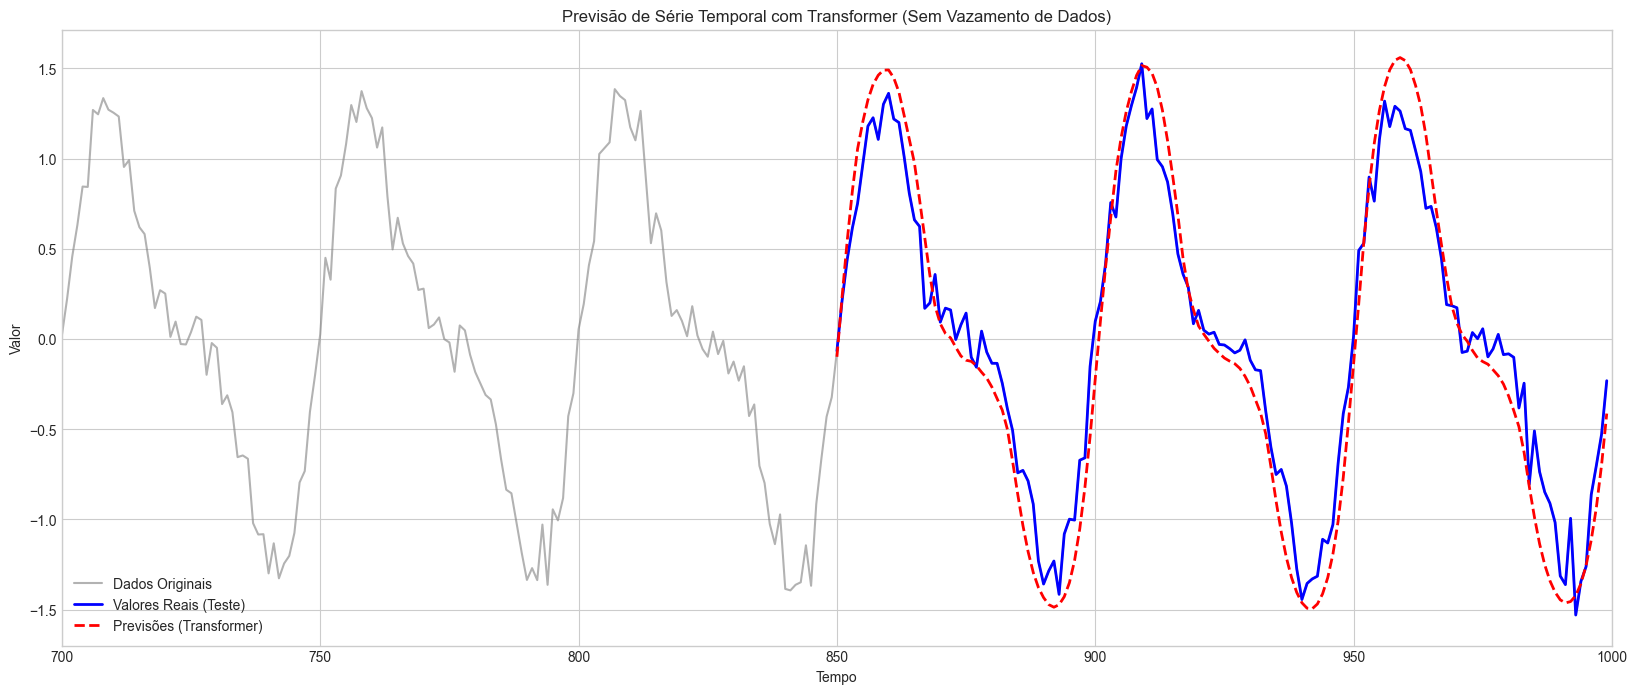

In [51]:
# Cria a figura
plt.figure(figsize = (20, 8))

# Série original completa (sem normalização)
plt.plot(np.arange(len(serie)), serie, label = 'Dados Originais', color = 'gray', alpha = 0.6)

# Eixo de tempo do conjunto de teste
test_start = len(serie_train) # ponto onde começa o teste
test_time_axis = np.arange(test_start + input_window, len(serie))

# Plotar os valores reais e as previsões
plt.plot(test_time_axis, y_test_original, label = 'Valores Reais (Teste)', color = 'blue', linewidth = 2)
plt.plot(test_time_axis, actual_predictions, label = 'Previsões (Transformer)', color = 'red', linestyle = '--', linewidth = 2)

plt.title("Previsão de Série Temporal com Transformer (Sem Vazamento de Dados)")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)

# Zoom na região de teste
plt.xlim(test_start - 100, len(serie))
plt.show()

## Deploy do Modelo

In [52]:
# Função para forecast
def dsa_previsao_futuro(model, start_sequence, future_steps):
    """
    Prevê múltiplos passos no futuro de forma autorregressiva.
    """
    model.eval()
    
    # Lista para guardar as previsões futuras
    future_predictions = []
    
    # A sequência atual começa com os dados de entrada
    current_sequence = start_sequence.clone().detach()

    # Desativa os gradientes
    with torch.no_grad():

        # Loop pelos passos futuros no tempo
        for i in range(future_steps):
            
            # Prever o próximo passo
            next_pred = modelo_dsa(current_sequence.unsqueeze(0)) # Adiciona dimensão de lote
            
            # Guardar a previsão
            future_predictions.append(next_pred.item())
            
            # Atualizar a sequência: remove o primeiro ponto e adiciona a previsão no final
            # O shape de next_pred é [1, 1], precisamos ajustá-lo para [1, 1, 1] para concatenar
            next_pred_tensor = torch.tensor([[next_pred.item()]], device = device)
            current_sequence = torch.cat((current_sequence[1:], next_pred_tensor), dim = 0)
            
    return np.array(future_predictions)

Vamos usar a função para fazer previsões.

In [53]:
# --- Usando a função para prever o futuro ---

# 1. Pegar a última sequência do nosso dataset como ponto de partida
last_sequence_real = X_test[-1].to(device)

# 2. Definir quantos passos no futuro queremos prever
steps_to_forecast = 200

# 3. Gerar o forecast
future_forecast_normalized = dsa_previsao_futuro(modelo_dsa, last_sequence_real, steps_to_forecast)

# 4. Desnormalizar os resultados para a escala original
future_forecast = scaler.inverse_transform(future_forecast_normalized.reshape(-1, 1))

In [54]:
# Imprimindo as primeiras linhas do vetor com as previsões
future_forecast[0:5]

array([[-0.41292604],
       [-0.09857523],
       [ 0.21704408],
       [ 0.51010251],
       [ 0.80052621]])

Vamos visualizar tudo junto: treino, teste e previsões.

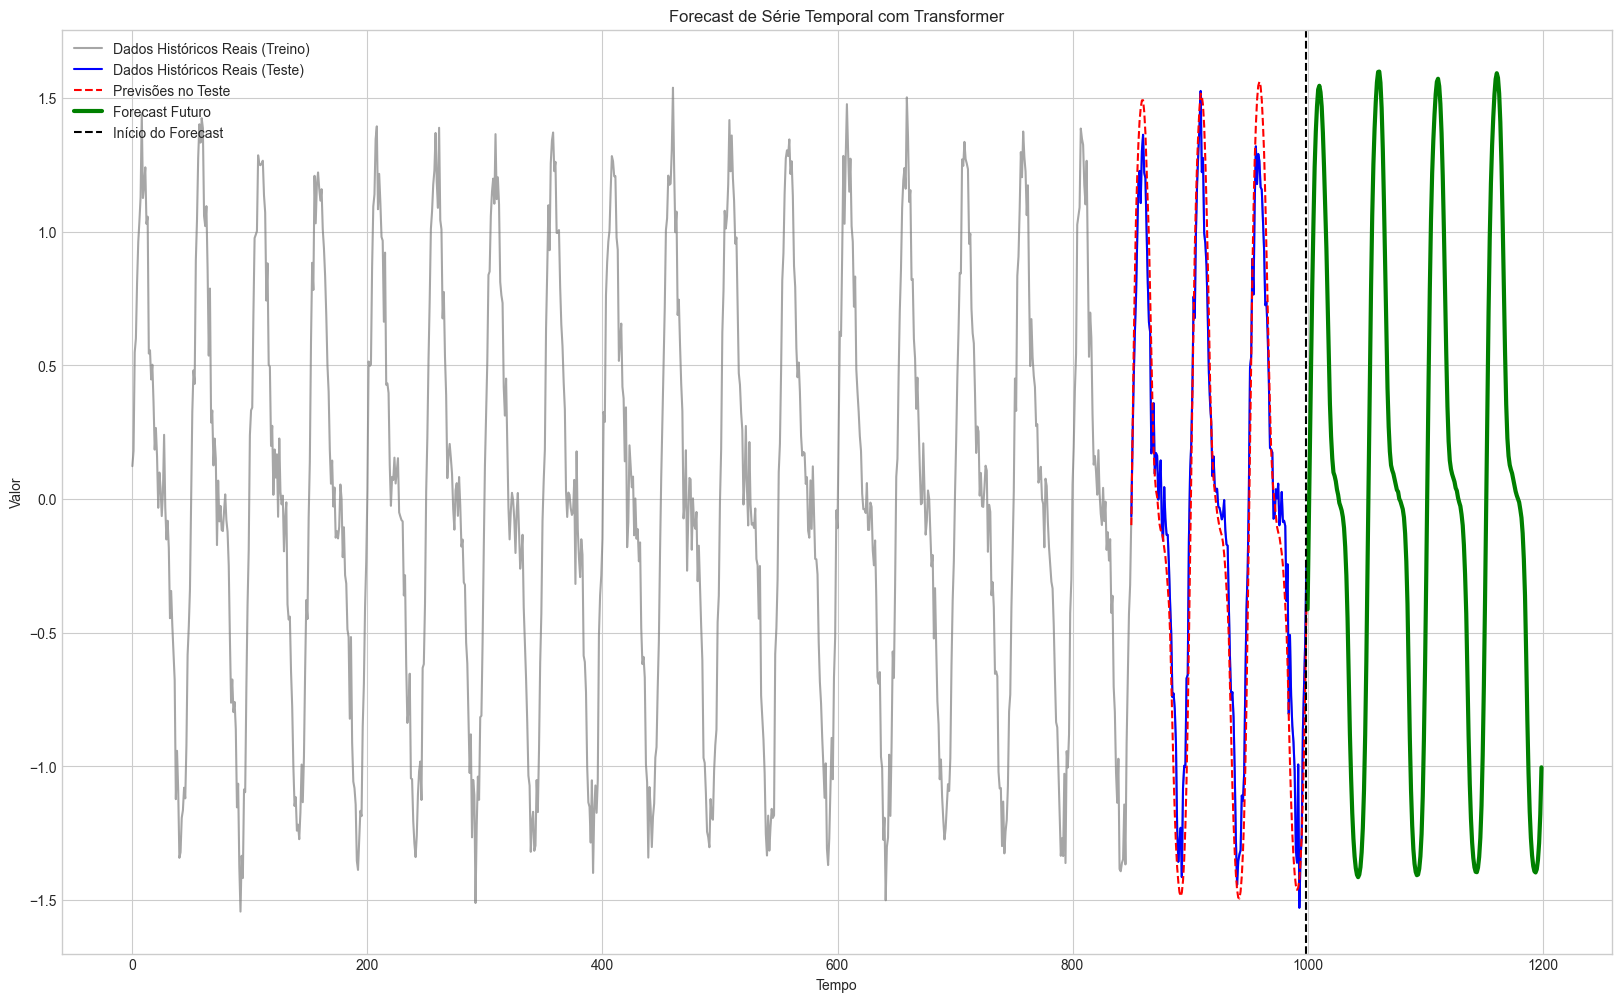

In [55]:
# Cria a figura para o plot
plt.figure(figsize = (20, 12))

# Série temporal original completa
plt.plot(np.arange(len(serie)), serie, label = 'Dados Históricos Reais (Treino)', color = 'gray', alpha = 0.7)

# Eixo de tempo do conjunto de teste (baseado na divisão original)
test_start = len(serie_train)
test_time_axis = np.arange(test_start + input_window, len(serie))

# Previsões no conjunto de teste
plt.plot(test_time_axis, y_test_original, label = 'Dados Históricos Reais (Teste)', color = 'blue')
plt.plot(test_time_axis, actual_predictions, label = 'Previsões no Teste', color = 'red', linestyle = '--')

# Forecast 
future_time_axis = np.arange(len(serie), len(serie) + steps_to_forecast)
plt.plot(future_time_axis, future_forecast, label = 'Forecast Futuro', color = 'green', linewidth = 3)

# Linha vertical indicando o início do forecast
plt.axvline(x = len(serie)-1, color = 'black', linestyle = '--', label = 'Início do Forecast')

plt.title("Forecast de Série Temporal com Transformer")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [55]:
#%watermark -v -m

In [56]:
#%watermark --iversions

# Fim